In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import h5py
import numpy as np

from vit_pytorch import ViT

sys.path.append("/home/lord225/pyrepos/explain-rl")

from ppo import PPO
import procgenwrapper


MODEL_PATH = "/home/lord225/pyrepos/explain-rl/preserve"
DATA_PATH = "/home/lord225/pyrepos/explain-rl/explain/records"

MODEL_NAME = "20250319-212023-ParentKnowShake_29_v3.1"

MODEL_PATH = os.path.join(MODEL_PATH, MODEL_NAME)
DATA_PATH = os.path.join(DATA_PATH, MODEL_NAME+"_replay.h5")


venv = procgenwrapper.ProcGenWrapper("starpilot", human=False, collect_seg=True)


model = PPO.load(MODEL_PATH, 
                 env=venv, 
                 print_system_info=True,
                 custom_objects={
                     "ViT":ViT,
                 })

# f.create_dataset("observations", data=np.array(observations, dtype=np.uint8))
# f.create_dataset("actions", data=np.array(actions))
# f.create_dataset("rewards", data=np.array(rewards))
# f.create_dataset("dones", data=np.array(dones))
# f.create_dataset("seg_observations", data=np.array(seg_observations, dtype=np.uint8))
# f.create_dataset("next_observations", data=np.array(next_observations, dtype=np.uint8))

dataset = h5py.File(DATA_PATH, "r")

observations = np.array(dataset["observations"])
actions = np.array(dataset["actions"])
rewards = np.array(dataset["rewards"])
dones = np.array(dataset["dones"])
seg_observations = np.array(dataset["seg_observations"])
next_observations = np.array(dataset["next_observations"])

dataset.close() 

print(observations.shape)

2025-03-20 21:30:26.279618: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 21:30:26.313687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 21:30:26.313726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-20 21:30:26.315516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 21:30:26.322446: I tensorflow/core/platform/cpu_feature_guar

building procgen...done
== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35 # 1 SMP Fri Mar 29 23:14:13 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 3.1.1
- Gymnasium: 1.0.0
- OpenAI Gym: 0.26.2

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
(10000, 64, 64, 9)


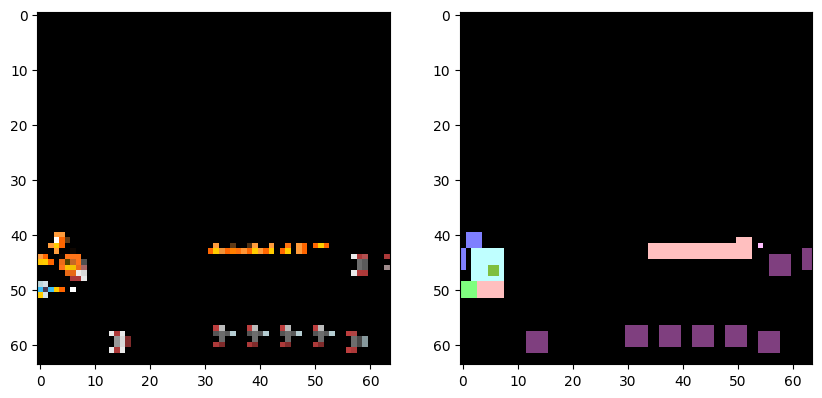

In [2]:
import matplotlib.pyplot as plt

def get_img(obs):
    return obs[:, :, 6:9]

ax, fig = plt.subplots(1, 2, figsize=(10, 5))

fig[0].imshow(get_img(observations[100]))
fig[1].imshow(seg_observations[100])

plt.show()

In [3]:
import imageio
import tqdm

def create_gif(observations, seg_observations, filename='output.gif', duration=0.1):
    frames = []
    for i in tqdm.tqdm(range(len(observations))):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(get_img(observations[i]))
        ax[1].imshow(seg_observations[i])
        plt.close(fig)
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(image)
    
    # Save the frames as a gif
    imageio.mimsave(filename, frames, duration=duration)

# create_gif(observations[:300], seg_observations[:300])

100%|██████████| 300/300 [00:29<00:00, 10.27it/s]


In [4]:
net = model.policy

net

CustomActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): CustomNetwork(
    (policy_net): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(9, 64, 64))
      (1): ViT(
        (to_patch_embedding): Sequential(
          (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
          (1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
          (2): Linear(in_features=144, out_features=64, bias=True)
          (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (transformer): Transformer(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (layers): ModuleList(
            (0-3): 4 x Mod

In [5]:
# Reshape the observations to match the expected input shape
obs_tensor = th.tensor(observations[:1].reshape((1, -1)), dtype=th.float32, device=net.device)

# Pass the tensor through the action_net
features_a, features_b = net.mlp_extractor(obs_tensor)

print(features_a.shape, features_b.shape)

torch.Size([1, 64]) torch.Size([1, 64])


In [6]:
# Get the action logits
action_logits = net.action_net(features_a)

print(action_logits.shape)

torch.Size([1, 15])


In [7]:
vit = net.mlp_extractor.policy_net
vit

Sequential(
  (0): Unflatten(dim=1, unflattened_size=(9, 64, 64))
  (1): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=144, out_features=64, bias=True)
      (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): Transformer(
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-3): 4 x ModuleList(
          (0): Attention(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=64, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=64, bias=True)
              (1): Dropout(p=0.1, inpl

In [8]:
observations[:1].shape

(1, 64, 64, 9)

In [9]:
vit = net.mlp_extractor.policy_net[1]
action_net = net.action_net

vit(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cuda())

tensor([[-2.8837, -0.1371,  0.3956, -0.8866, -3.0618, -0.2293,  0.4853, -0.4020,
          6.6181,  0.0430, -0.1739,  0.6156,  0.4764,  0.6566,  0.2312,  1.3945,
         -1.5027, -0.4992,  4.2064, -4.6301, -0.5014, -0.0801, -0.1777,  0.3860,
          0.5314, -0.1908,  2.9518,  0.4651,  1.7628,  0.0462,  0.8507, -2.3137,
         -0.4550, -0.3317,  1.6050,  0.5979, -0.0309,  0.0502,  0.0509,  0.5242,
         -0.0106, -0.5018,  0.0566,  3.6061, -1.1753, -1.2471, -1.4254, -0.2167,
         -0.3652, -0.1440,  0.4525,  6.5460, -0.0487,  1.6479,  0.1897, -0.3337,
         -0.3102, -1.0874, -0.0477,  0.0114,  0.4342,  0.5210,  2.4043,  0.3127]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [10]:
vrobas = action_net(vit(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cuda()))

In [11]:
from vit_pytorch.extractor import Extractor
from vit_pytorch.recorder import Recorder

extractor = Extractor(vit)
recorder = Recorder(vit)


# Emdedding

In [12]:
probas, extracted = extractor(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cuda())

probas.shape, extracted.shape

(torch.Size([1, 64]), torch.Size([1, 257, 64]))

# Attention

In [13]:
probas, attention = recorder(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cuda())

probas.shape, attention.shape

(torch.Size([1, 64]), torch.Size([1, 4, 4, 257, 257]))

In [14]:
import cv2
def attention_map(attention, image):
    # avg attention over heads
    attention = np.array(attention).mean(axis=1)

    grid_size = int(np.sqrt(attention.shape[-1] - 1))
    num_layers = attention.shape[0]
    num_heads = attention.shape[1]
    reshaped = attention.reshape(
        (num_layers, num_heads, grid_size**2 + 1, grid_size**2 + 1)
    )

    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])

    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
        ..., np.newaxis
    ]
    return mask

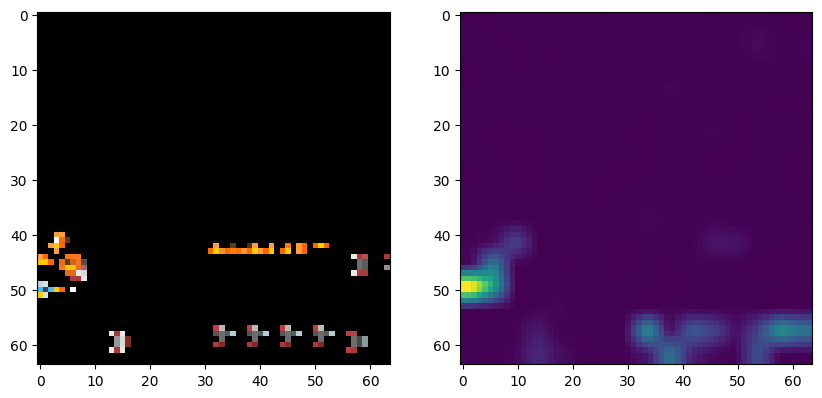

In [15]:
obs = th.tensor(observations[100]).reshape(-1, 64, 64, 9).permute(0, 3, 1, 2).float().cuda()

probas, attention = recorder(obs)

map = attention_map(attention.cpu().detach().numpy(), observations[100])

# plot both
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(get_img(observations[100]))
ax[1].imshow(map)

plt.show()